In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
sys.path.append('../src')
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle, save_pickle

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms

def load_class_names(dataset_path=''):
    names = {}
    with open(os.path.join(dataset_path, 'classes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            class_id = pieces[0]
            names[class_id] = ' '.join(pieces[1:])
    return names

In [6]:
# Script runtime options
model = 'resnext101_64x4d'
root_dir = '..'
data_root_dir = os.path.join(root_dir, 'data_nabirds')
model_root_dir = os.path.join(root_dir, 'nabirds_models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images_sorted')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'na_birds_{}_full.pth'.format(model))

In [7]:
# Get data transforms
data_transforms = makeTransforms()

In [8]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}

class_labels = load_class_names(dataset_path=data_root_dir)
class_names = []
for class_id in image_datasets['test'].classes:
    class_names.append( '{} - {}'.format(class_id, class_labels[str(int(class_id))]) )
    
num_classes = len(class_names)

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


Number of data
test  size::  24633  images

Number of classes::  555
0 :: 0295 - Common Eider (Adult male) :: 29
1 :: 0296 - Long-tailed Duck (Winter male) :: 30
2 :: 0297 - Ruddy Duck (Breeding male) :: 38
3 :: 0298 - Swainson's Hawk (Dark morph ) :: 30
4 :: 0299 - Red-tailed Hawk (Light morph adult) :: 60
5 :: 0313 - Snow Goose (White morph) :: 26
6 :: 0314 - Wood Duck (Breeding male) :: 60
7 :: 0315 - Gadwall (Breeding male) :: 56
8 :: 0316 - American Wigeon (Breeding male) :: 45
9 :: 0317 - Mallard (Breeding male) :: 60
10 :: 0318 - Blue-winged Teal (Male) :: 42
11 :: 0319 - Cinnamon Teal (Male) :: 55
12 :: 0320 - Northern Shoveler (Breeding male) :: 60
13 :: 0321 - Northern Pintail (Breeding male) :: 42
14 :: 0322 - Green-winged Teal (Male) :: 41
15 :: 0323 - Canvasback (Breeding male) :: 43
16 :: 0324 - Redhead (Breeding male) :: 27
17 :: 0325 - Ring-necked Duck (Breeding male) :: 44
18 :: 0326 - Greater Scaup (Breeding male) :: 43
19 :: 0327 - Lesser Scaup (Breeding male) :: 44


In [9]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


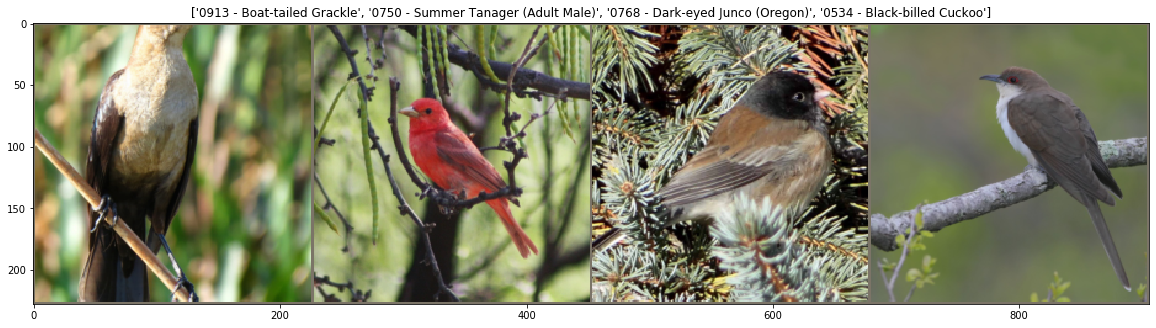

In [10]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
# Load the best model from file
model_ = torch.load(model_file)

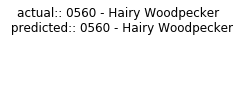

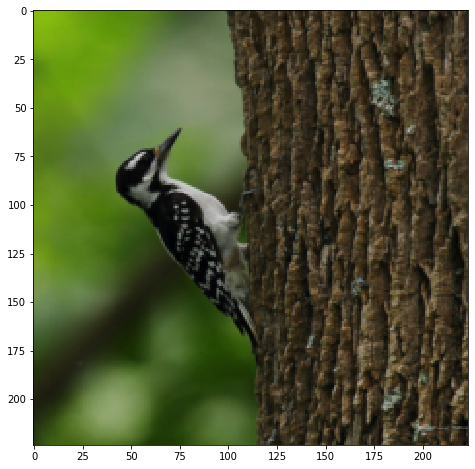

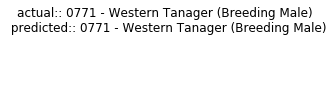

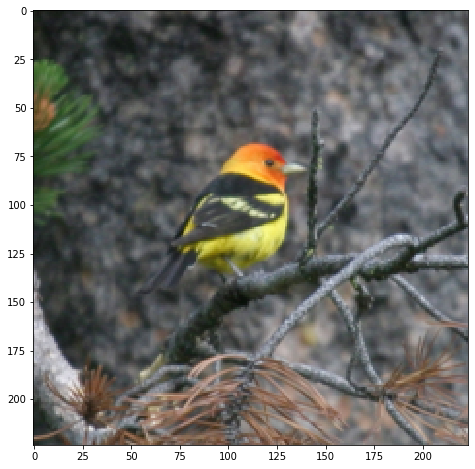

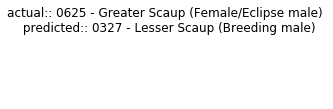

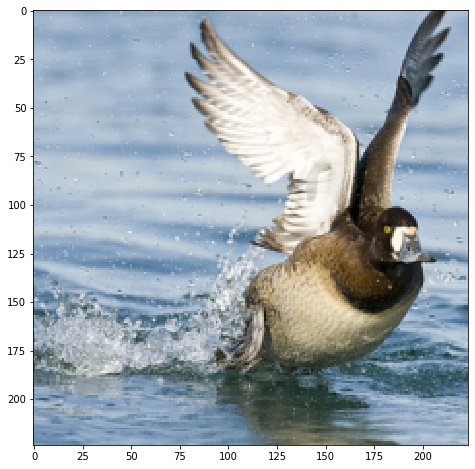

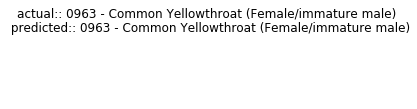

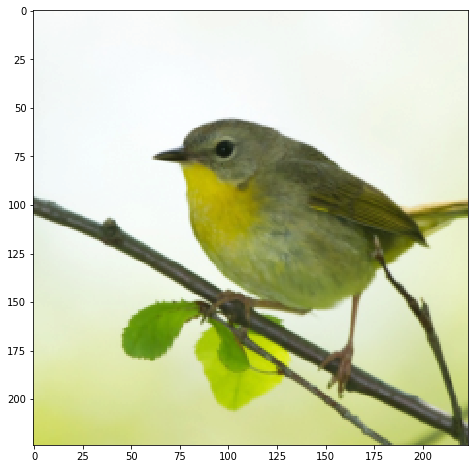

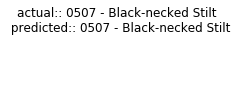

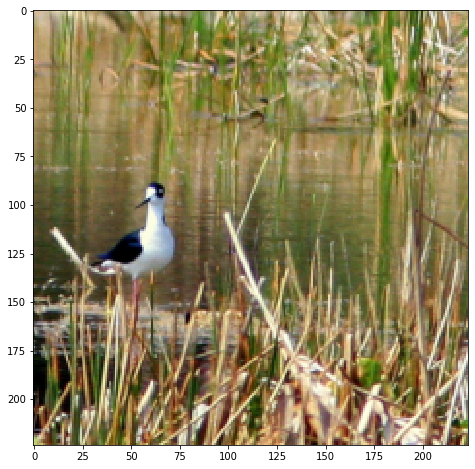

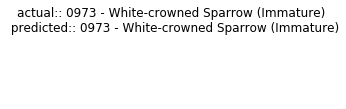

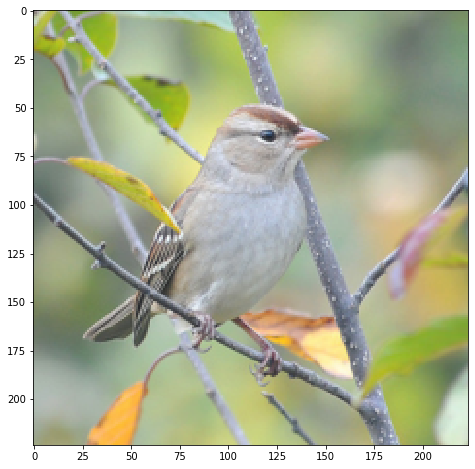

In [12]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [13]:
# Load model training history
history = unpickle(model_history)

In [14]:
history.keys()

dict_keys(['epoch', 'train_loss', 'test_loss', 'train_acc', 'test_acc'])

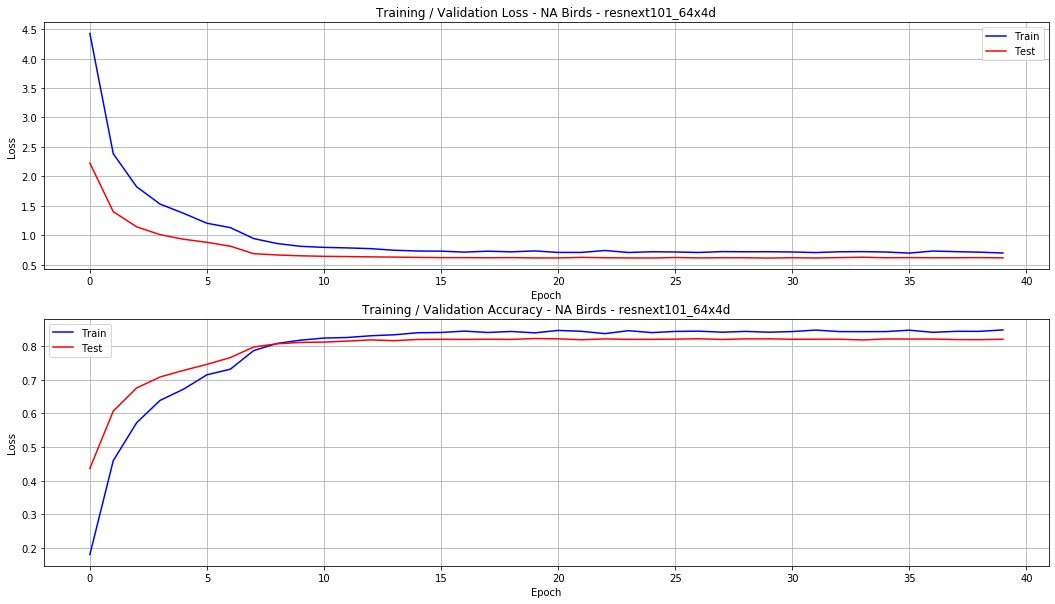

In [15]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - NA Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - NA Birds - {}'.format(model))
plt.legend()

plt.show()

In [16]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
            scores_pred = outputs.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
            scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

print('Complete.')

results_dict = {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..1450..1475..1500..1525..1550..1575..1600..1625..1650..1675..1700..1725..1750..1775..1800..1825..1850..1875..1900..1925..1950..1975..2000..2025..2050..2075..2100..2125..2150..2175..2200..2225..2250..2275..2300..2325..2350..2375..2400..2425..2450..2475..2500..2525..2550..2575..2600..2625..2650..2675..2700..2725..2750..2775..2800..2825..2850..2875..2900..2925..2950..2975..3000..3025..3050..3075..3100..3125..3150..3175..3200..3225..3250..3275..3300..3325..3350..3375..3400..3425..3450..3475..3500..3525..3550..3575..3600..3625..3650..3675..3700..3725..3750..3775..3800..3825..3850..3875..3900..3925..3950..3975..4000..4025..4050..4075..4100..4125..4150..4175..420

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [18]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

                                                                  precision    recall  f1-score   support

                                0295 - Common Eider (Adult male)       0.96      0.93      0.95        29
                           0296 - Long-tailed Duck (Winter male)       0.93      0.87      0.90        30
                               0297 - Ruddy Duck (Breeding male)       0.92      0.95      0.94        38
                            0298 - Swainson's Hawk (Dark morph )       0.42      0.37      0.39        30
                      0299 - Red-tailed Hawk (Light morph adult)       0.77      0.67      0.71        60
                                 0313 - Snow Goose (White morph)       0.64      0.62      0.63        26
                                0314 - Wood Duck (Breeding male)       0.94      1.00      0.97        60
                                  0315 - Gadwall (Breeding male)       0.78      0.84      0.81        56
                          0316 - American Wig

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

0295 - Common Eider (Adult male)  \
precision                          0.964286   
recall                             0.931034   
f1-score                           0.947368   
support                           29.000000   

           0296 - Long-tailed Duck (Winter male)  \
precision                               0.928571   
recall                                  0.866667   
f1-score                                0.896552   
support                                30.000000   

           0297 - Ruddy Duck (Breeding male)  \
precision                           0.923077   
recall                              0.947368   
f1-score                            0.935065   
support                            38.000000   

           0298 - Swainson's Hawk (Dark morph )  \
precision                              0.423077   
recall                                 0.366667   
f1-score                               0.392857   
support                               30.000000   

           0299 - Red-tailed Hawk (Light morph adult)  \
precision                                    0.769231   
recall                                       0.666667   
f1-score                                     0.714286   
support                                     60.000000   

           0313 - Snow Goose (White morph)  0314 - Wood Duck (Breeding male)  \
precision                         0.640000                          0.937500   
recall                            0.615385                          1.000000   
f1-score                          0.627451                          0.967742   
support                          26.000000                         60.000000   

           0315 - Gadwall (Breeding male)  \
precision                        0.783333   
recall                           0.839286   
f1-score                         0.810345   
support                         56.000000   

           0316 - American Wigeon (Breeding male)  \
precision                                0.862745   
recall                                   0.977778   
f1-score                                 0.916667   
support                                 45.000000   

           0317 - Mallard (Breeding male)  ...  \
precision                        1.000000  ...   
recall                           0.933333  ...   
f1-score                         0.965517  ...   
support                         60.000000  ...   

           1004 - Vermilion Flycatcher (Female, immature)  \
precision                                        0.870968   
recall                                           0.750000   
f1-score                                         0.805970   
support                                         36.000000   

           1005 - European Starling (Juvenile)  \
precision                             0.852941   
recall                                0.828571   
f1-score                              0.840580   
support                              35.000000   

           1006 - Fox Sparrow (Thick-billed/Slate-colored)  \
precision                                           0.7500   
recall                                              0.1875   
f1-score                                            0.3000   
support                                            16.0000   

           1007 - Summer Tanager (Immature Male)  \
precision                               0.857143   
recall                                  0.705882   
f1-score                                0.774194   
support                                17.000000   

           1008 - Orchard Oriole (Female/Juvenile)  \
precision                                 0.485714   
recall                                    0.653846   
f1-score                                  0.557377   
support                                  26.000000   

           1009 - Yellow-rumped Warbler (Winter/juvenile Audubon's)  \
precision                                           0.638298          
recall                                       

In [20]:
class_report_df['accuracy']['precision']

0.8230422603824138

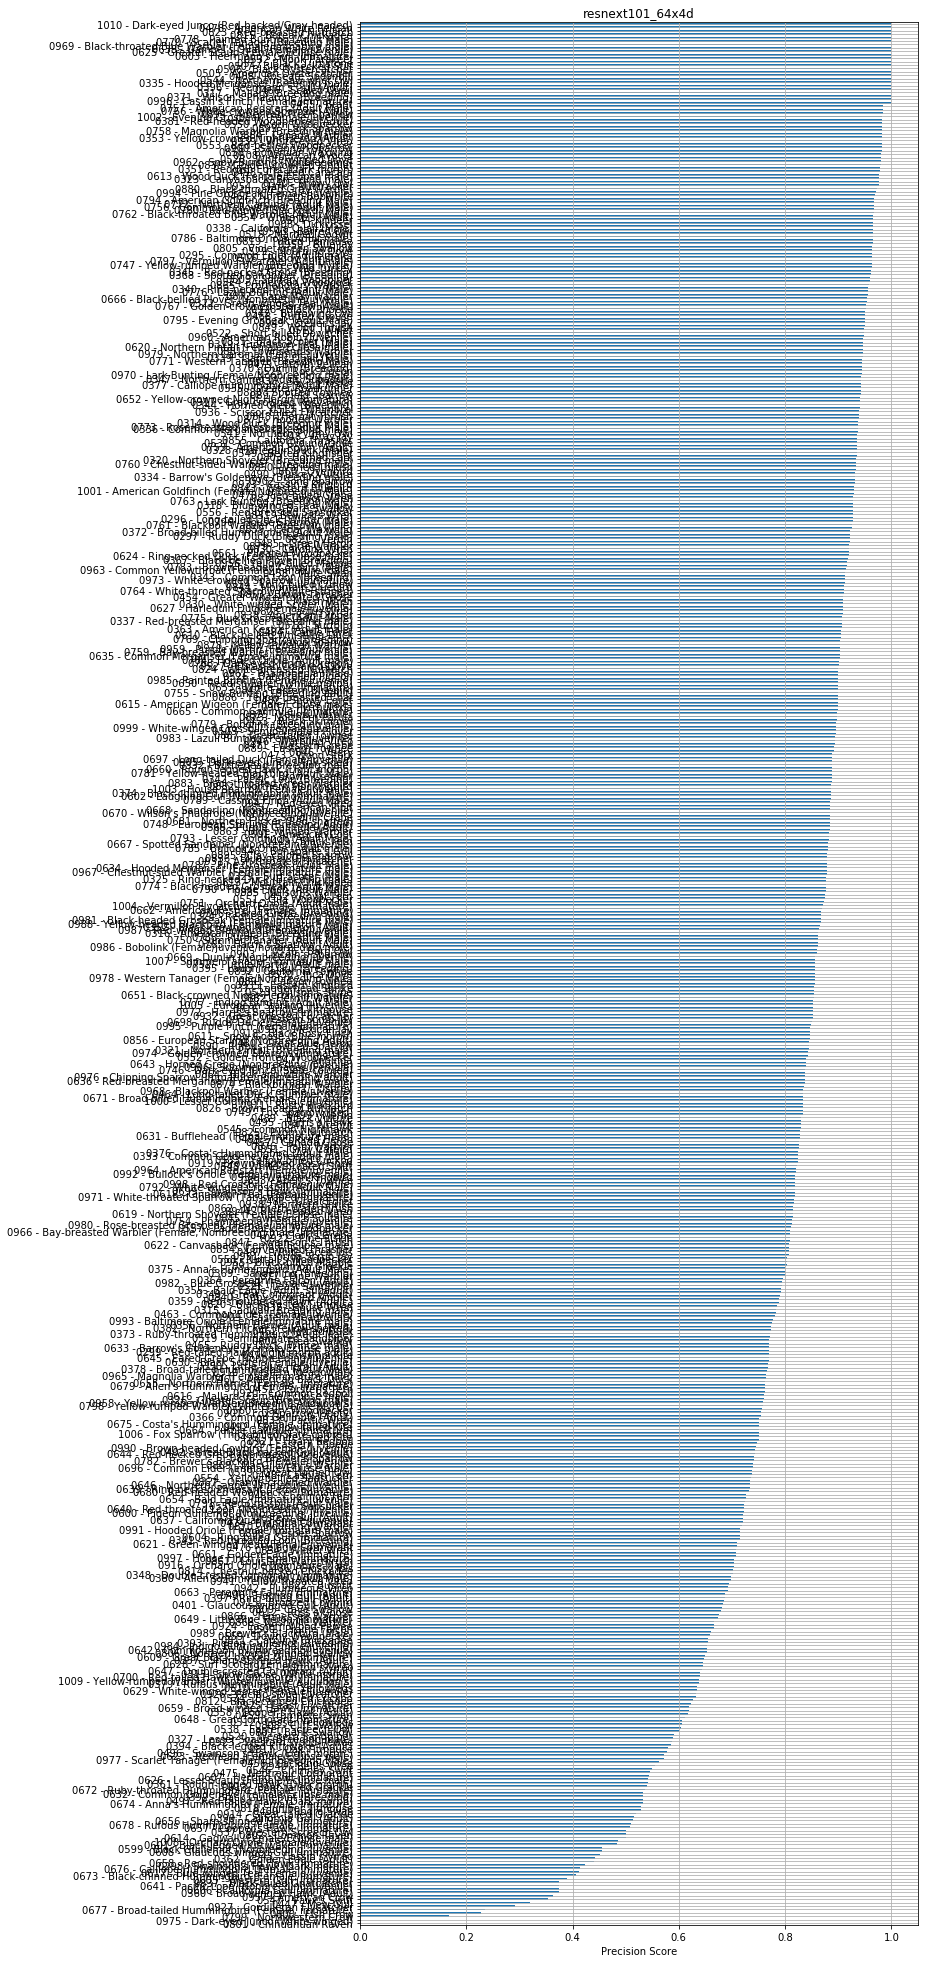

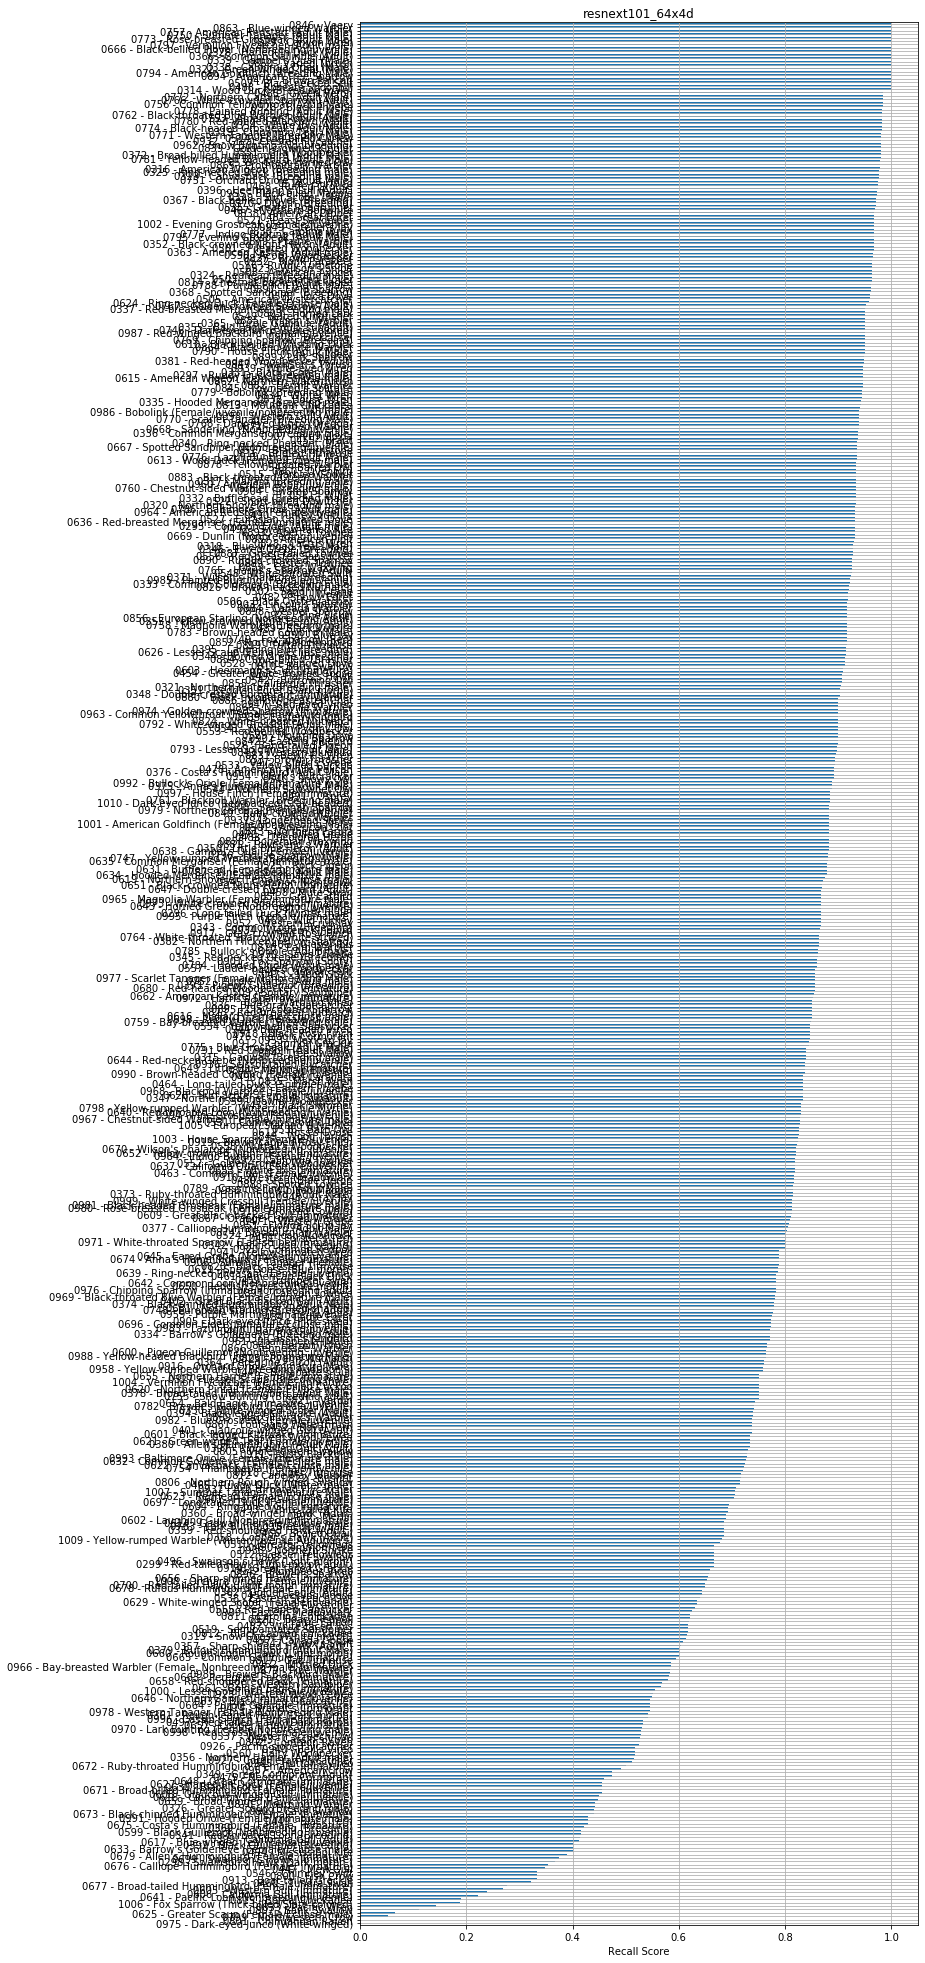

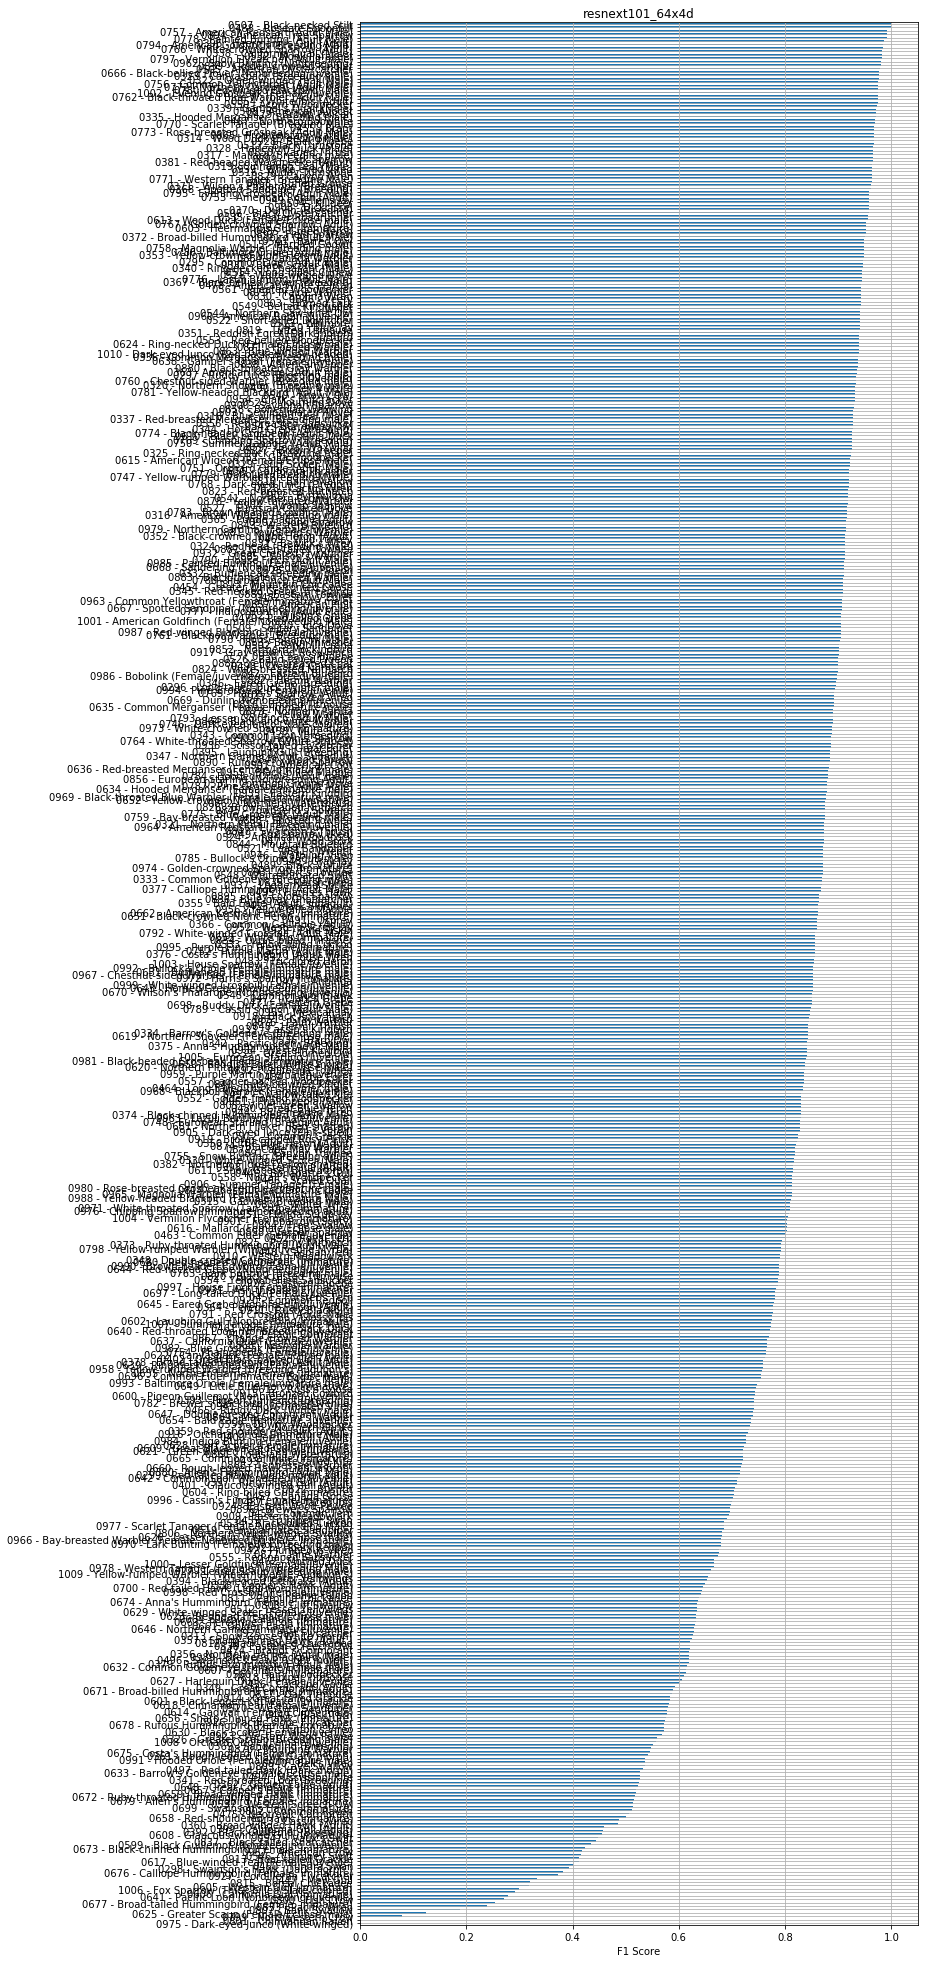

In [21]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [22]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

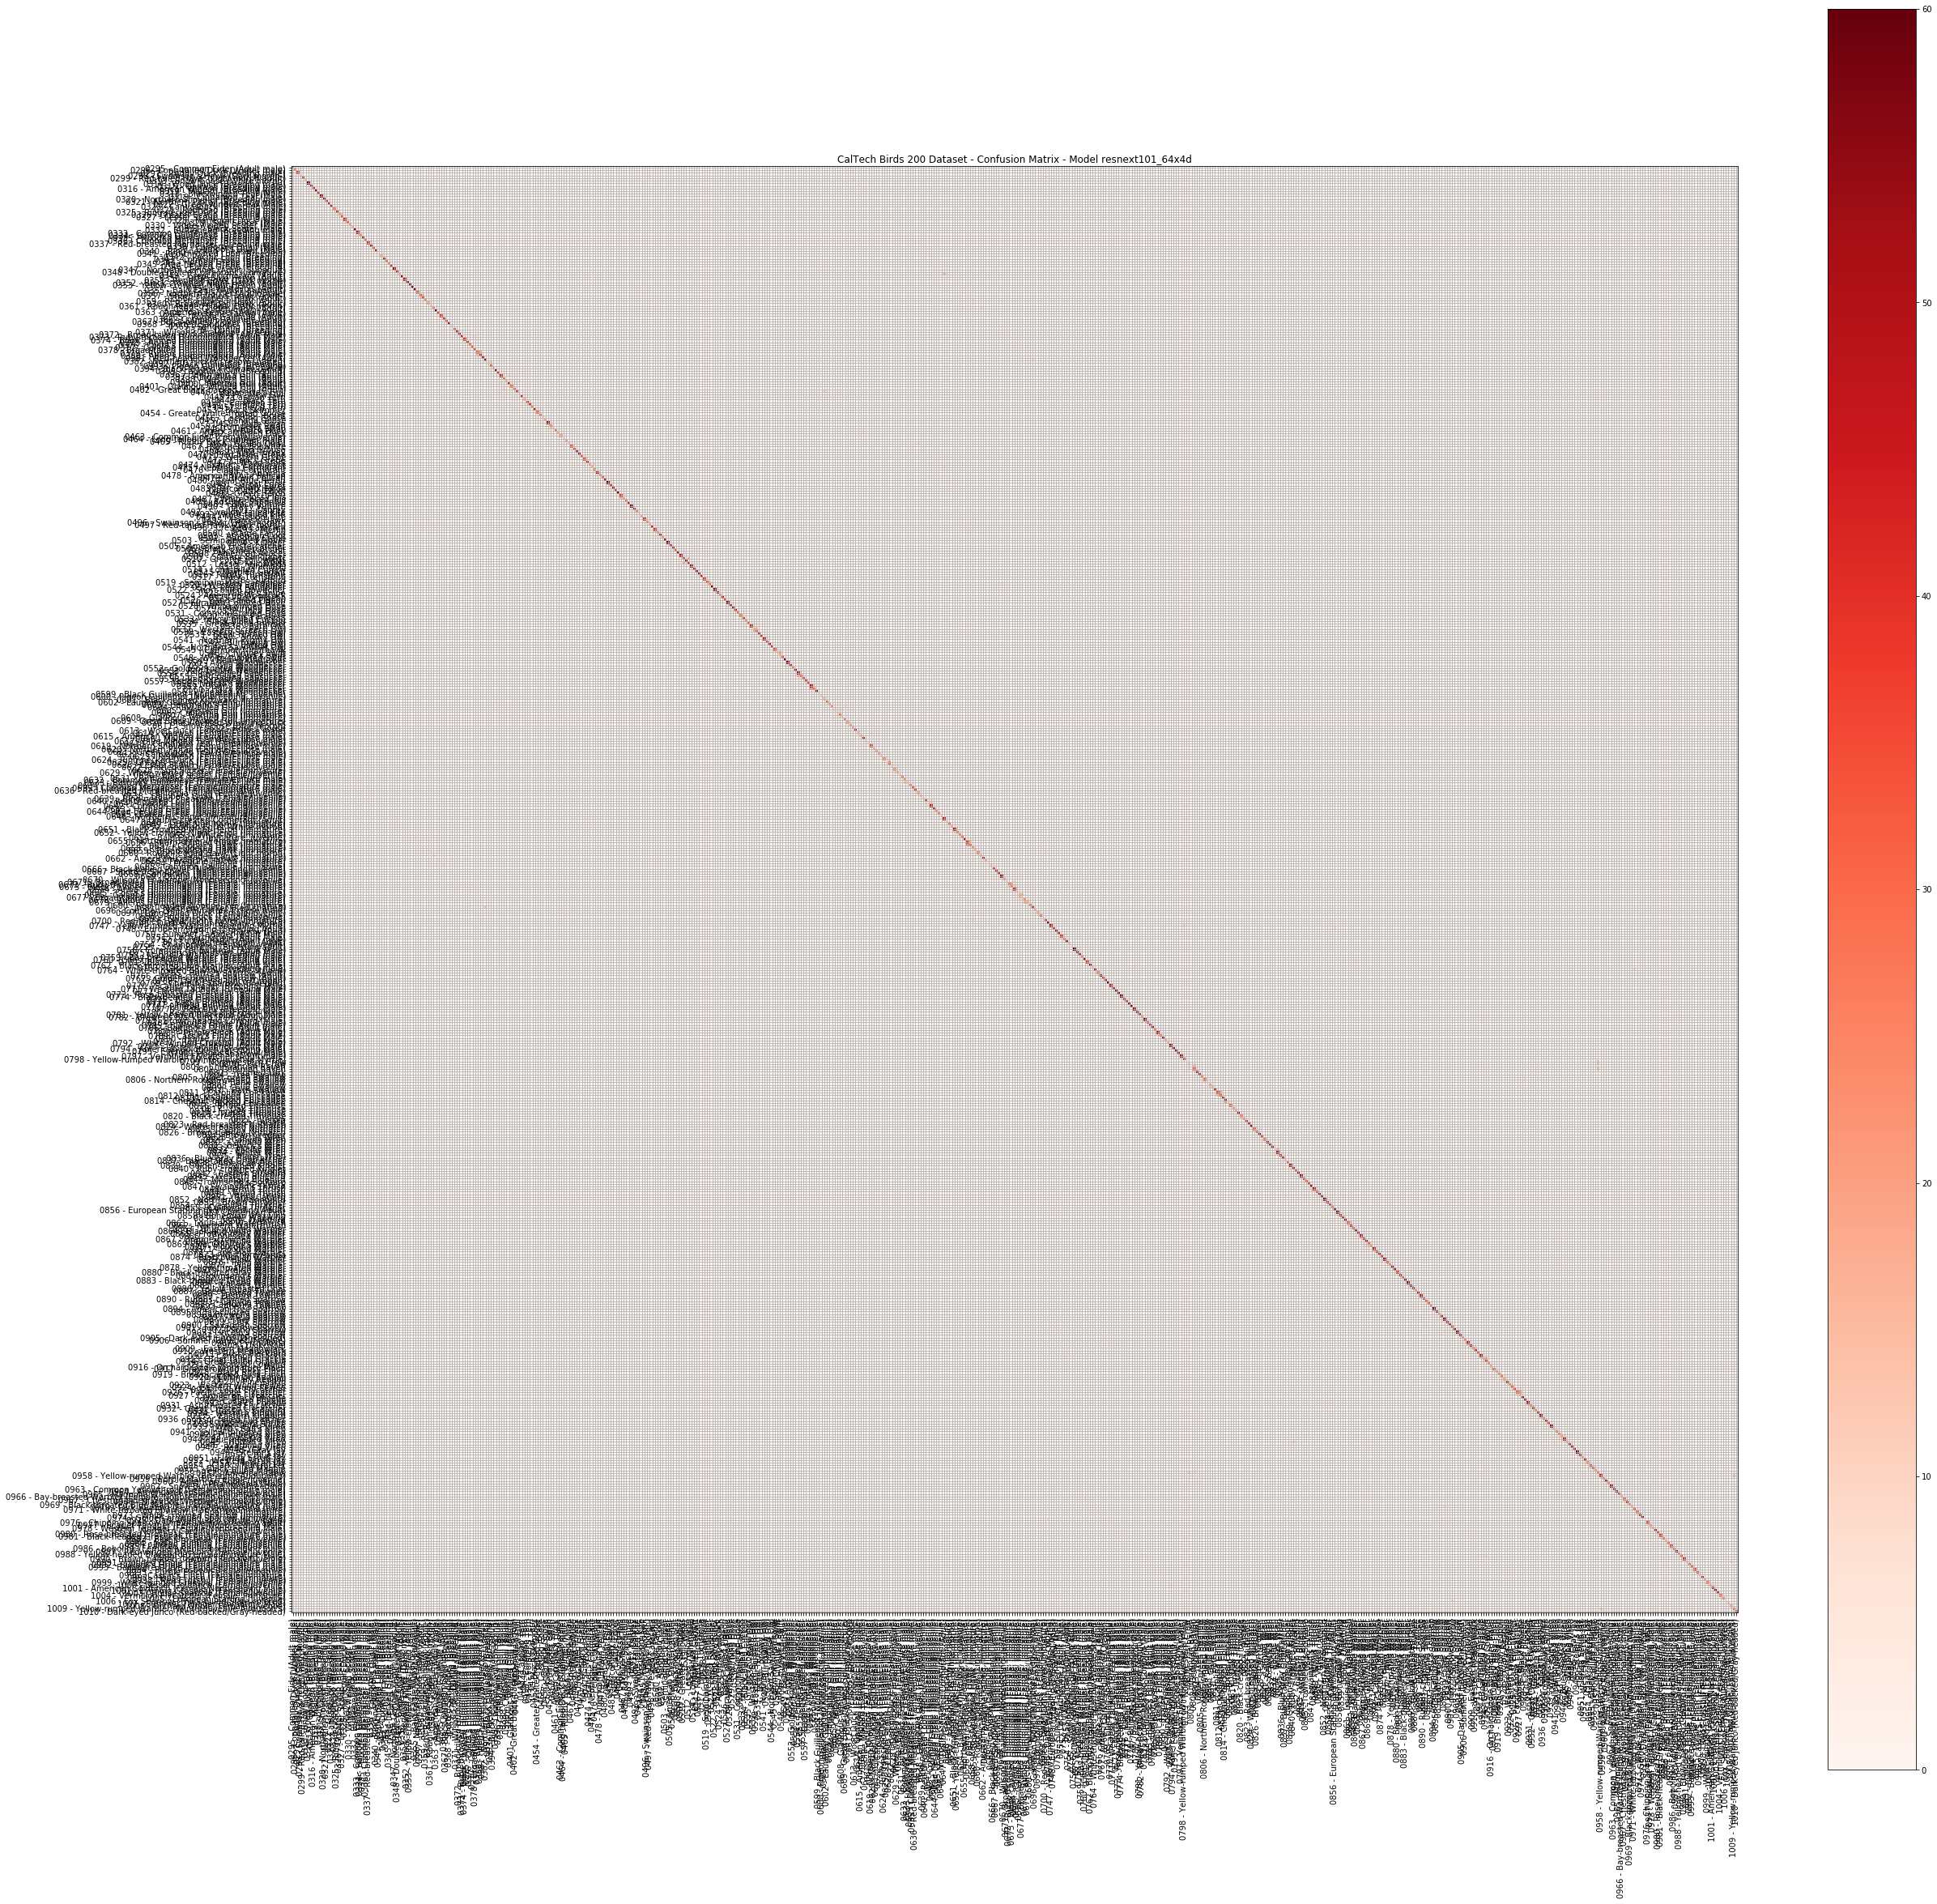

In [23]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [24]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))